# Assignment 12: Fairness
### Due July 18 at 12:00

Please note: 

- Read the instructions in the exercise PDF and in this notebook carefully.
- Add your solutions *only* at `YOUR CODE HERE`/`YOUR ANSWER HERE` and remove the corresponding `raise NotImplementedError()`.
- Do not change the provided code and text, if not stated.
- Do not *add* or *delete* cells.
- Do not `import` additional functionality. 
- Before submitting: Please make sure, that your notebook can be executed from top to bottom `Menu -> Kernel -> Restart & Run all`. 

Author: Michael Lohaus

In [4]:
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from numpy.testing import assert_almost_equal

%matplotlib inline
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

Let's load the data. Note that is has already been preprocessed. 

**The dataset contains the binary variable 'race' which will be our senstive attribute.**

The value 1 encodes 'African-American' and 0 stands for 'Caucasian'.

In [5]:
compas_df = pd.read_csv('compas.csv')
y = compas_df.pop('two_year_recid') # target label
s = compas_df['race'] # sensitive attribute
X = compas_df.values # features (here, still including the sensitive attribute)

In [6]:
# data playground
print(f"{y.shape=} - {s.shape=} - {X.shape=}")
print(f"{np.unique(y)=} - {np.unique(s)=}")
print(f"{X[0]=}")
print(f"{X.mean(axis=0)=}")

y.shape=(5278,) - s.shape=(5278,) - X.shape=(5278, 8)
np.unique(y)=array([0, 1]) - np.unique(s)=array([0, 1])
X[0]=array([34,  0,  0, 10,  3,  1,  0,  1])
X.mean(axis=0)=array([34.44941266,  0.19533914,  3.46153846, 15.12087912,  4.62277378,
        0.65176203,  0.34823797,  0.60155362])


## Exercise 1

### a)

Let's prepare a few functions for this exercise. Given true labels `y_true` and predictions `y_pred`, we want to compute the positive predictive value, the false positive rate, the false negative rate, and the prevalence (base rate) of recidivism. 

In [7]:
def get_positive_predictive_value(y_true, y_pred):
    n = y_true.shape[0]
    tp = y_pred[y_true == 1].sum()
    return 0 if n == 0 else tp/n

def get_false_positive_rate(y_true, y_pred):
    n = y_true.shape[0]
    fp = y_pred[y_true == 0].sum()
    neg = (y_true == 0).sum()
    return 0 if n == 0 else fp/neg
    
def get_false_negative_rate(y_true, y_pred):
    n = y_true.shape[0]
    inv_y_pred = (y_pred - 1) * (-1)
    fn = inv_y_pred[y_true == 1].sum()
    pos = (y_true == 1).sum()

    return 0 if n == 0 else fn/pos
    
def get_prevalence(y_true):
    n = y_true.shape[0]
    pos = y_true.sum()
    return 0 if n == 0 else pos/n

In [8]:
y_pred_ones = np.ones_like(y)
assert_almost_equal(get_prevalence(y), 0.47044334975369456)
assert_almost_equal(get_false_positive_rate(y, y_pred_ones), 1)
assert_almost_equal(get_false_negative_rate(y, y_pred_ones), 0)


With the help of these functions, we now want to compute the group-wise **positive predictive value**, the **false positive rate**, and the **false negative rate**. Given a threshold decile score s_0, we predict y=1, if s>=s_0 and 0 otherwise. Compute these values for each group and each possible threshold s_0 (**from 1 to 10**) and save it in the arrays provided.  

Additionally, we want to check the **group-wise prevalence given a score** (for calibration).

In [9]:
# to make this cell repeatable in exec
# compas_df = pd.read_csv('compas.csv') 
# y = compas_df.pop('two_year_recid')


decile_scores = compas_df.pop('decile_score') # decile score from 1 to 10
calibration = np.zeros(shape=(2,10)) # 2 rows for two groups, 10 columns for 10 possible thresholds. 
predictive_value = np.zeros(shape=(2,10))
fp_rate = np.zeros(shape=(2,10))
fn_rate = np.zeros(shape=(2,10))


for i, s_0 in enumerate(np.sort(decile_scores.unique())):
    y_pred = (decile_scores >= s_0).astype(int)
    for group in range(2):
        mask = np.logical_and(y_pred, (s == group)) 

        group_labels = y[mask]
        group_pred = y_pred[mask]
        
        calibration[group,i] = get_prevalence(group_labels)
        predictive_value[group, i] = get_positive_predictive_value(group_labels, group_pred)

        group_labels = y[s == group]
        group_pred = y_pred[s == group]

        fp_rate[group, i] = get_false_positive_rate(group_labels, group_pred)
        fn_rate[group, i] = get_false_negative_rate(group_labels, group_pred)

# print(calibration)
# print(fn_rate)
# print(fp_rate)
# print(predictive_value)

In [10]:
assert_almost_equal(calibration[0,9], 0.7)
assert_almost_equal(calibration[1,9], 0.8370044052863436)
assert_almost_equal(fn_rate[0,0], 0)
assert_almost_equal(fp_rate[1,0], 1) 
assert_almost_equal(predictive_value[1,5], 0.6839309428950863)

# WARNING
# These assertions enfore calibration == predictive_value
assert_almost_equal(calibration, predictive_value)

Now, we create a 2-by-2 plot displaying the results. Each plot contains two bars (for the two groups) per decile score. The barheights correspond to the rates computed above. With these plots, take a closer look at calibration, predictive parity, false positive rates, and false negative rates (aka equality of opportunity). 

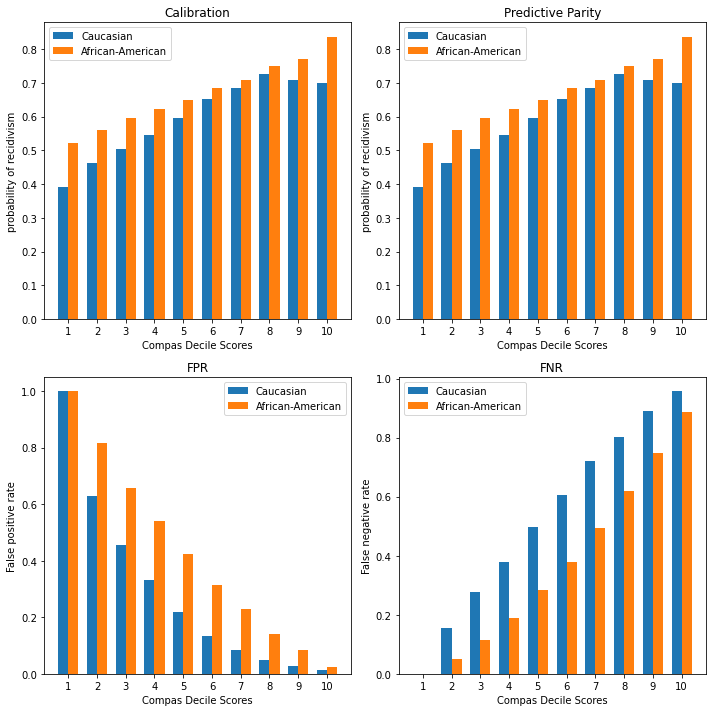

In [11]:
# plotting the assessment
fig, axs = plt.subplots(2,2, figsize=(10,10))

labels = [i+1 for i in range(10)]
x = np.arange(10)  # the label locations
width = 0.35  # the width of the bars
titles = ['Calibration', 'Predictive Parity', 'FPR', 'FNR']
y_labels = ['probability of recidivism', 'probability of recidivism', 'False positive rate', 'False negative rate']
values = [calibration, predictive_value, fp_rate, fn_rate]


for ax_id, ax in enumerate(axs.flatten()):
    rects1 = ax.bar(x - width/2, values[ax_id][0,:], width, label='Caucasian')
    rects2 = ax.bar(x + width/2, values[ax_id][1,:], width, label='African-American')


    ax.set_xlabel('Compas Decile Scores')
    ax.set_ylabel(y_labels[ax_id])
    ax.set_title(titles[ax_id])
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend()
    
fig.tight_layout()
plt.show()

What are your main observations? Address each plot shortly and consider the case, where we use 6 as the decision threshold. Which fairness notions are roughly fulfilled and which aren't?

1. from the predicitve parity (and calibration) plot, we can see that Predictive parity is fullfilled
2. from the fp plot we can see that equalized odds are not fullfilled  
   __note:__ the fp/fn arrays are calculated differently from calibration and positive parity, as otherwise they would by definition be all 1s and 0s
   


Assuming our decision threshold is fair with respect to Calibration and Predictive Parity, could we also achieve Equalized Odds? 

To answer this question, solve the **theoretical questions 1 b) and 1 c)** on the assignment pdf. 

### c) (ii)

Check the condition obtained from the theoretical results in the following cell.

In [12]:
# YOUR CODE HERE

### d)

Now, let's use our own classifier. We dropped the decile scores from the data before, and we use the remaining data. 

In [13]:
x_train, x_test, y_train, y_test, s_train, s_test = train_test_split(compas_df,y,s, train_size = 0.5)

Write a function that evaluates the predictions. As an output, it should give the **group-wise** predictive value, false positive and false negative rates, and accuracy. 

In [19]:
# Evaluate
def evaluate_results(y_pred, y_test, s_test):

    # Note the shape: We want to evaluate group-wise
    accuracy = np.zeros(shape=s_test.shape)
    predictive_value = np.zeros(shape=s_test.shape)
    fp_rate = np.zeros(shape=s_test.shape)
    fn_rate = np.zeros(shape=s_test.shape)
    
    for group in s_test.unique():
        group_y_test = y_test[s_test == group]
        group_y_pred = y_pred[s_test == group]
        predictive_value[group] = get_positive_predictive_value(group_y_test, group_y_pred)
        fp_rate[group] = get_false_positive_rate(group_y_test, group_y_pred)
        fn_rate[group] = get_false_negative_rate(group_y_test, group_y_pred)
        accuracy[group] = (group_y_test == group_y_pred).sum() / group_y_test.size
    
    return predictive_value, fp_rate, fn_rate, accuracy

In [20]:
def plot_fairness_assessment(predictive_values, fp_rate, fn_rate, accuracy):
    x = np.arange(1)  # the label locations
    width = 0.35  # the width of the bars
    titles = ['Predictive Parity', 'FPR', 'FNR', 'Accuracy']
    y_labels = ['probability of recidivism', 'False positive rate', 'False negative rate', 'Accuracy']
    values = [predictive_values, fp_rate, fn_rate, accuracy]

    fig, axs = plt.subplots(1,4, figsize=(15,5))

    for ax_id, ax in enumerate(axs.flatten()):
        rects1 = ax.bar(x - width/2, values[ax_id][0], width, label='Caucasian')
        rects2 = ax.bar(x + width/2, values[ax_id][1], width, label='African-American')

        ax.set_ylabel(y_labels[ax_id])
        ax.set_title(titles[ax_id])
        ax.set_xticks(x)
        ax.legend()

    fig.tight_layout()
    plt.show()

Now, you are ready to train, evaluate and visualize the results of your own model. 

Train a Logistic Regression with l2 penalty, and C=1. Then, predict the test data, and plot the evaluations (evaluate_results) of the resulting classifier with plot_fairness_assessment. 

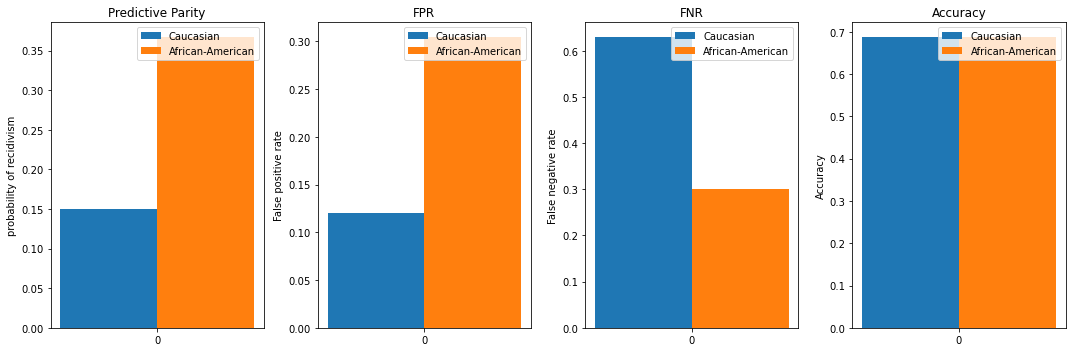

In [22]:
lr = LogisticRegression(C=1, penalty='l2')

lr.fit(x_train, y_train)
preds = lr.predict(x_test)
plot_fairness_assessment(*evaluate_results(preds, y_test, s_test))

Our features still included race! Lets drop this feature and train the logistic regression again. Does it make a difference? 

In [23]:
# lets drop the sensitive label
compas_df = compas_df.drop('race', axis=1)
x_train, x_test, y_train, y_test, s_train, s_test = train_test_split(compas_df,y,s, train_size = 0.5)

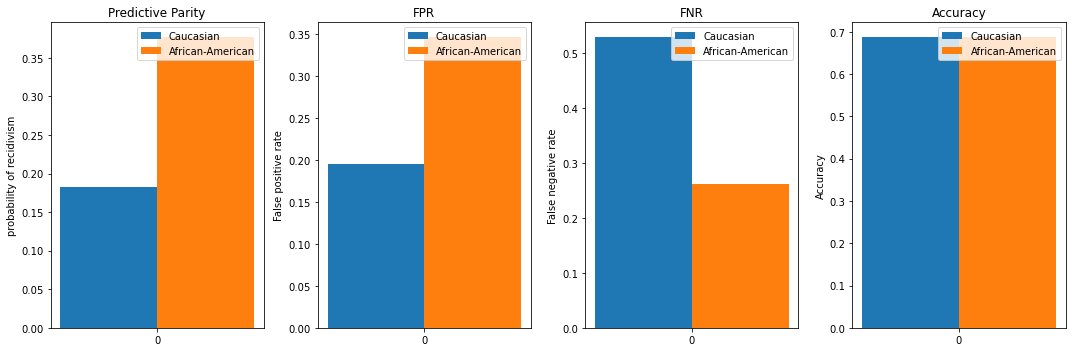

In [24]:
lr = LogisticRegression(C=1, penalty='l2')

lr.fit(x_train, y_train)
preds = lr.predict(x_test)
plot_fairness_assessment(*evaluate_results(preds, y_test, s_test))

Can you think of a simple way to improve fairness? Lets focus only on **equal false negative rates here (Equality of Opportunity)**. Play around with the regularization parameter of the logistic regression, and, as above, plot the evaluation results (for one fairer classifier). 

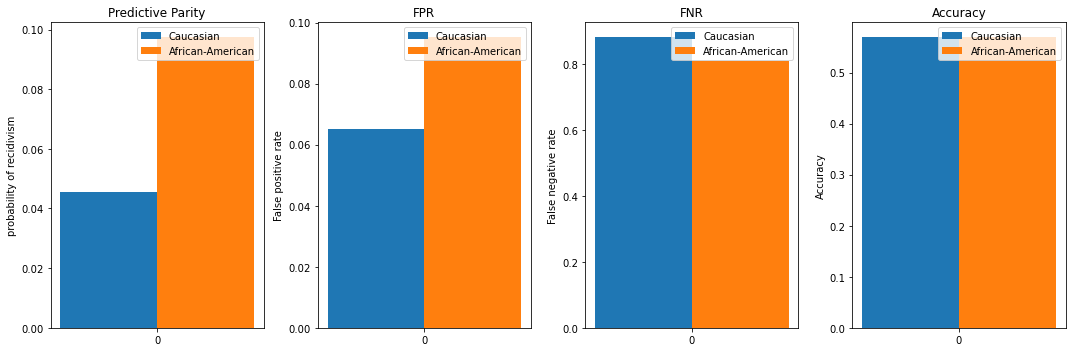

In [41]:
lr = LogisticRegression(C=.000002, penalty='l2')

lr.fit(x_train, y_train)
preds = lr.predict(x_test)
plot_fairness_assessment(*evaluate_results(preds, y_test, s_test))

Plot the **false negative rates of each group and the overall accuracy** as a function of the regularization parameter (that makes 3 lines in one plot) to show the trade-off you can achieve.

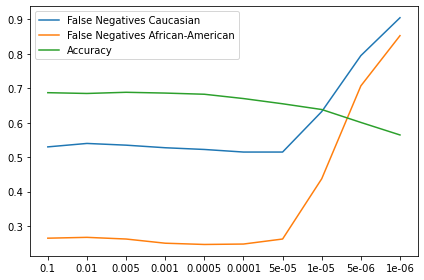

In [48]:
Cs = [0.1,0.01,0.005,0.001,0.0005,0.0001,0.00005,0.00001,0.000005,0.000001]
x = np.arange(len(Cs))
fig, ax = plt.subplots()

fn_rates_0 = np.zeros_like(Cs)
fn_rates_1 = np.zeros_like(Cs)
accuracys = np.zeros_like(Cs)

for i, C in enumerate(Cs):
    lr = LogisticRegression(C=C, penalty='l2')
    lr.fit(x_train, y_train)
    preds = lr.predict(x_test)
    evaluate_results(preds, y_test, s_test)
    fn_rates_0[i] = get_false_negative_rate(y_test[s_test == 0], preds[s_test == 0])
    fn_rates_1[i] = get_false_negative_rate(y_test[s_test == 1], preds[s_test == 1])
    accuracys[i] = (y_test == preds).sum() / y_test.size



# Use
ax.set_xticks(x)
ax.set_xticklabels(Cs)

ax.plot(x, fn_rates_0, label='False Negatives Caucasian')
ax.plot(x, fn_rates_1, label='False Negatives African-American')
ax.plot(x, accuracys, label='Accuracy')

ax.legend()
fig.tight_layout()
plt.show()

What is the problem with this rather naive-method? What is the trivial baseline here?

The baseline is, that there are features that are not correlated to the race, while still being significant in terms of the prediction.  
If this is not the case, just increasing regularization, would drop the accuracy to near 0.5 before achieving any fairness.